# **Modelling and Evaluation Notebook**

## Objectives

* Answer business requirement 2:
    - The client is interested to predict whether a cherry leaf is healthy or contains powdery mildew. 

## Inputs

* inputs/mildew_dataset/cherry-leaves/train
* inputs/mildew_dataset/cherry-leaves/test
* inputs/mildew_dataset/cherry-leaves/validation
* image shape embeddings

## Outputs

* Cherry Leave Images distribution plot in train, validation, and test dataset.

## Additional Comments

---

## Change working directory

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\All\\Desktop\\Zoe_Deve\\ML-Mildew-Detector-\\jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\All\\Desktop\\Zoe_Deve\\ML-Mildew-Detector-'

### Import libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread

### Set input directories for train, validation and test paths

In [5]:
my_data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

In [6]:
version = 'v1-mildew'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set label names

In [7]:
# Set the labels
labels = os.listdir(train_path)
print('Class Labels are', labels)

Class Labels are ['healthy', 'powdery_mildew']


### Set image shape

In [8]:
## Import image shape embedding saved at repo
version = 'v1-mildew'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## Plot number of images in train, test and validation dataset

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




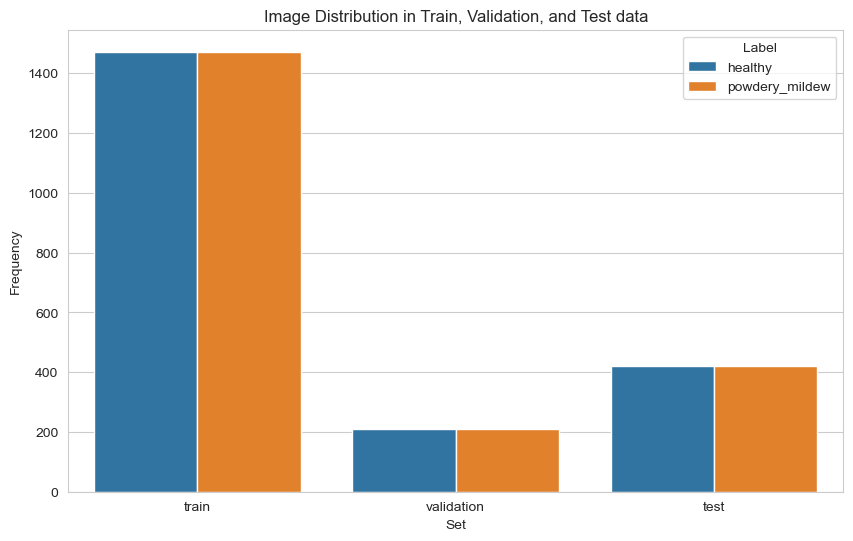

In [12]:
import glob

data_dirs = ['train', 'validation', 'test']

df_freq = pd.DataFrame([])

for folder in data_dirs:
    for label in os.listdir(os.path.join(my_data_dir, folder)):
        image_count = len(os.listdir(os.path.join(my_data_dir, folder, label)))
        df_freq = df_freq.append(pd.Series(data={'Set': folder, 'Label': label, 'Frequency': image_count}), ignore_index=True)
        print(f"* {folder} - {label}: {image_count} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))  
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.title("Image Distribution in Train, Validation, and Test data")
plt.xlabel("Set")
plt.ylabel("Frequency")
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

----

## Image data augmentation

## Set standardised Image shape

Compute average images size on train set.

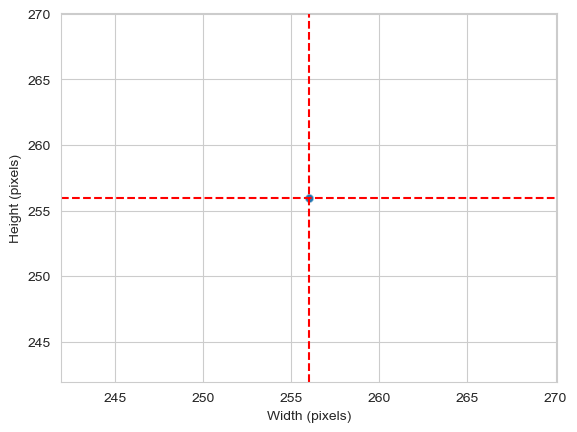

Width average: 256 
Height average: 256


In [10]:
# Below code is taken from CI walk through notebook
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

Assign the average width and height, and color channel to image_shape

In [11]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(256, 256, 3)

Save the image shape embeddings

In [12]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1-mildew/image_shape.pkl']

## Average and variability of images for healthy and powdery-mildew contained cherry leaves

### Load images in arrays (tensor)

In [13]:
from tensorflow.keras.preprocessing import image

In [14]:
# Below code is taken from CI walk through notebook
def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            # n_images_per_label: we set a limit, since it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

In [15]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 256, 256, 3) (60,)


Plot and save mean and variability of images for healthy and powdery-mildew contained cherry leaves

In [73]:
# Function was taken from CI training notebook with modefied colormap for better visulizaton
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    """
    The pseudo-code for the function is:
    * Loop over all labels
    * Subset an array for a given label
    * Calculate the mean and standard deviation
    * Create a figure displaying the mean and variability of images
    * Save the image
    """

    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='RdBu') 

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=200)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

==== Label healthy ====
Image Shape: (256, 256, 3)
==== Label powdery_mildew ====
Image Shape: (256, 256, 3)


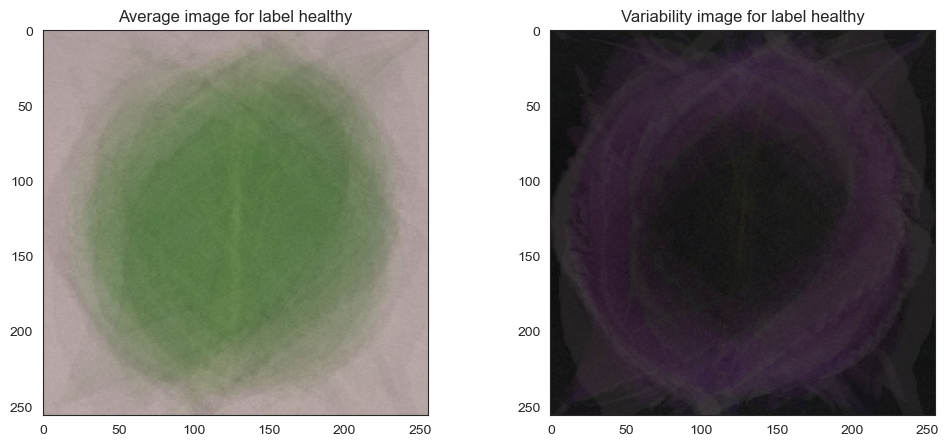

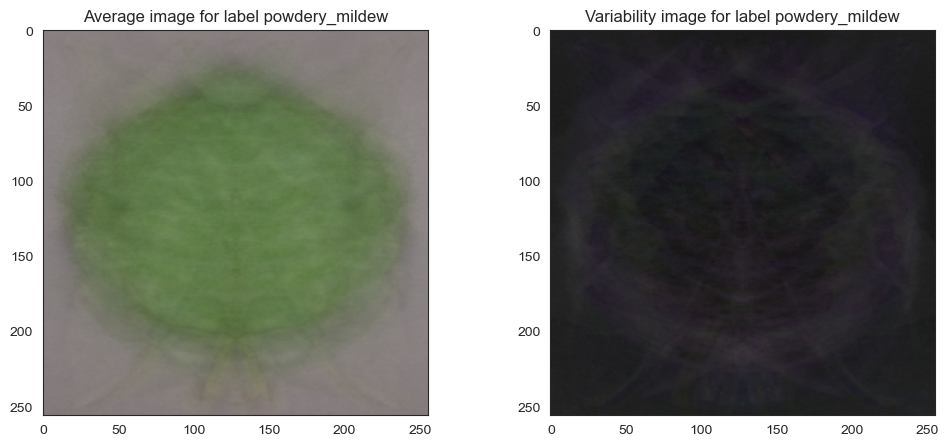

In [74]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True)

---

## Difference between average powdery-mildew-contained and average healthy cellcherry leave images

In [60]:
# Code was inspired by CI walk through project
# And modefied to enhace the visuability of the difference mean image
from skimage import exposure

def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(25, 5), save_image=False):
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(f"Either label {label_1} or label {label_2} is not in {np.unique(y)} ")
        return

    images_label1 = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label1, axis=0)

    images_label2 = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label2, axis=0)

    difference_mean = label1_avg - label2_avg

    # Apply histogram equalization for contrast enhancement
    difference_mean_equalized = exposure.equalize_hist(difference_mean)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean_equalized, cmap='gray')
    axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')

    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()

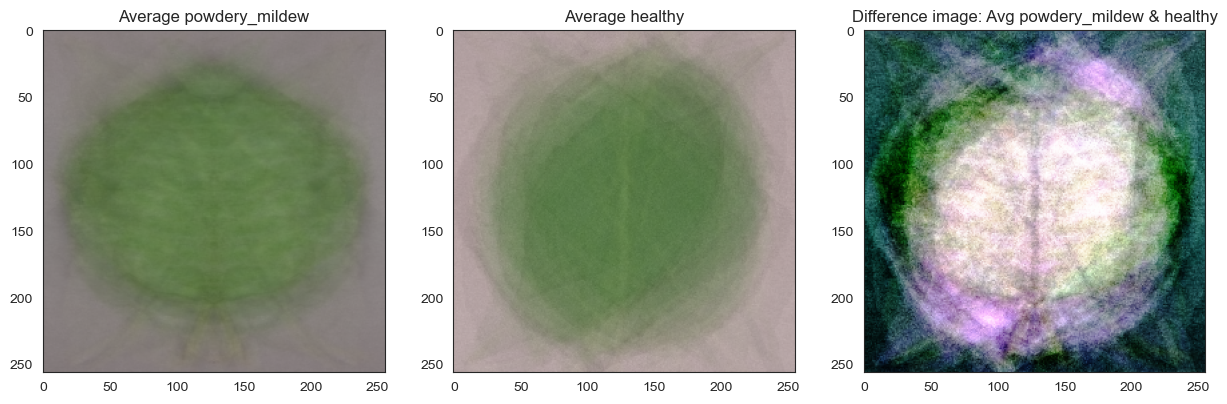

In [61]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='powdery_mildew', label_2='healthy',
                                        figsize=(15, 10),
                                        save_image=True
                                        )

## Image Montage


Run Montage in all labels

In [62]:
# Function was taken from CI training notebook
import itertools
import random
sns.set_style("white")


def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
    """
    if the label exists in the directory
    check if your montage space is greater than the subset size
    create a list of axes indices based on nrows and ncols
    create a Figure and display images
    in this loop, load and plot the given image
    """

    labels = os.listdir(dir_path)

    # subset the class you are interested to display
    if label_to_display in labels:

        # checks if your montage space is greater than the subset size
        images_list = os.listdir(dir_path + '/' + label_to_display)
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print(
                f"Decrease nrows or ncols to create your montage. \n"
                f"There are {len(images_list)} in your subset. "
                f"You requested a montage with {nrows * ncols} spaces")
            return

        # create a list of axes indices based on nrows and ncols
        list_rows = range(0, nrows)
        list_cols = range(0, ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        # create a Figure and display images
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0, nrows*ncols):
            img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
            img_shape = img.shape
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(
                f"Width {img_shape[1]}px x Height {img_shape[0]}px")
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        plt.tight_layout()
        plt.show()

    else:
        print("The label you selected doesn't exist.")
        print(f"The existing options are: {labels}")

healthy


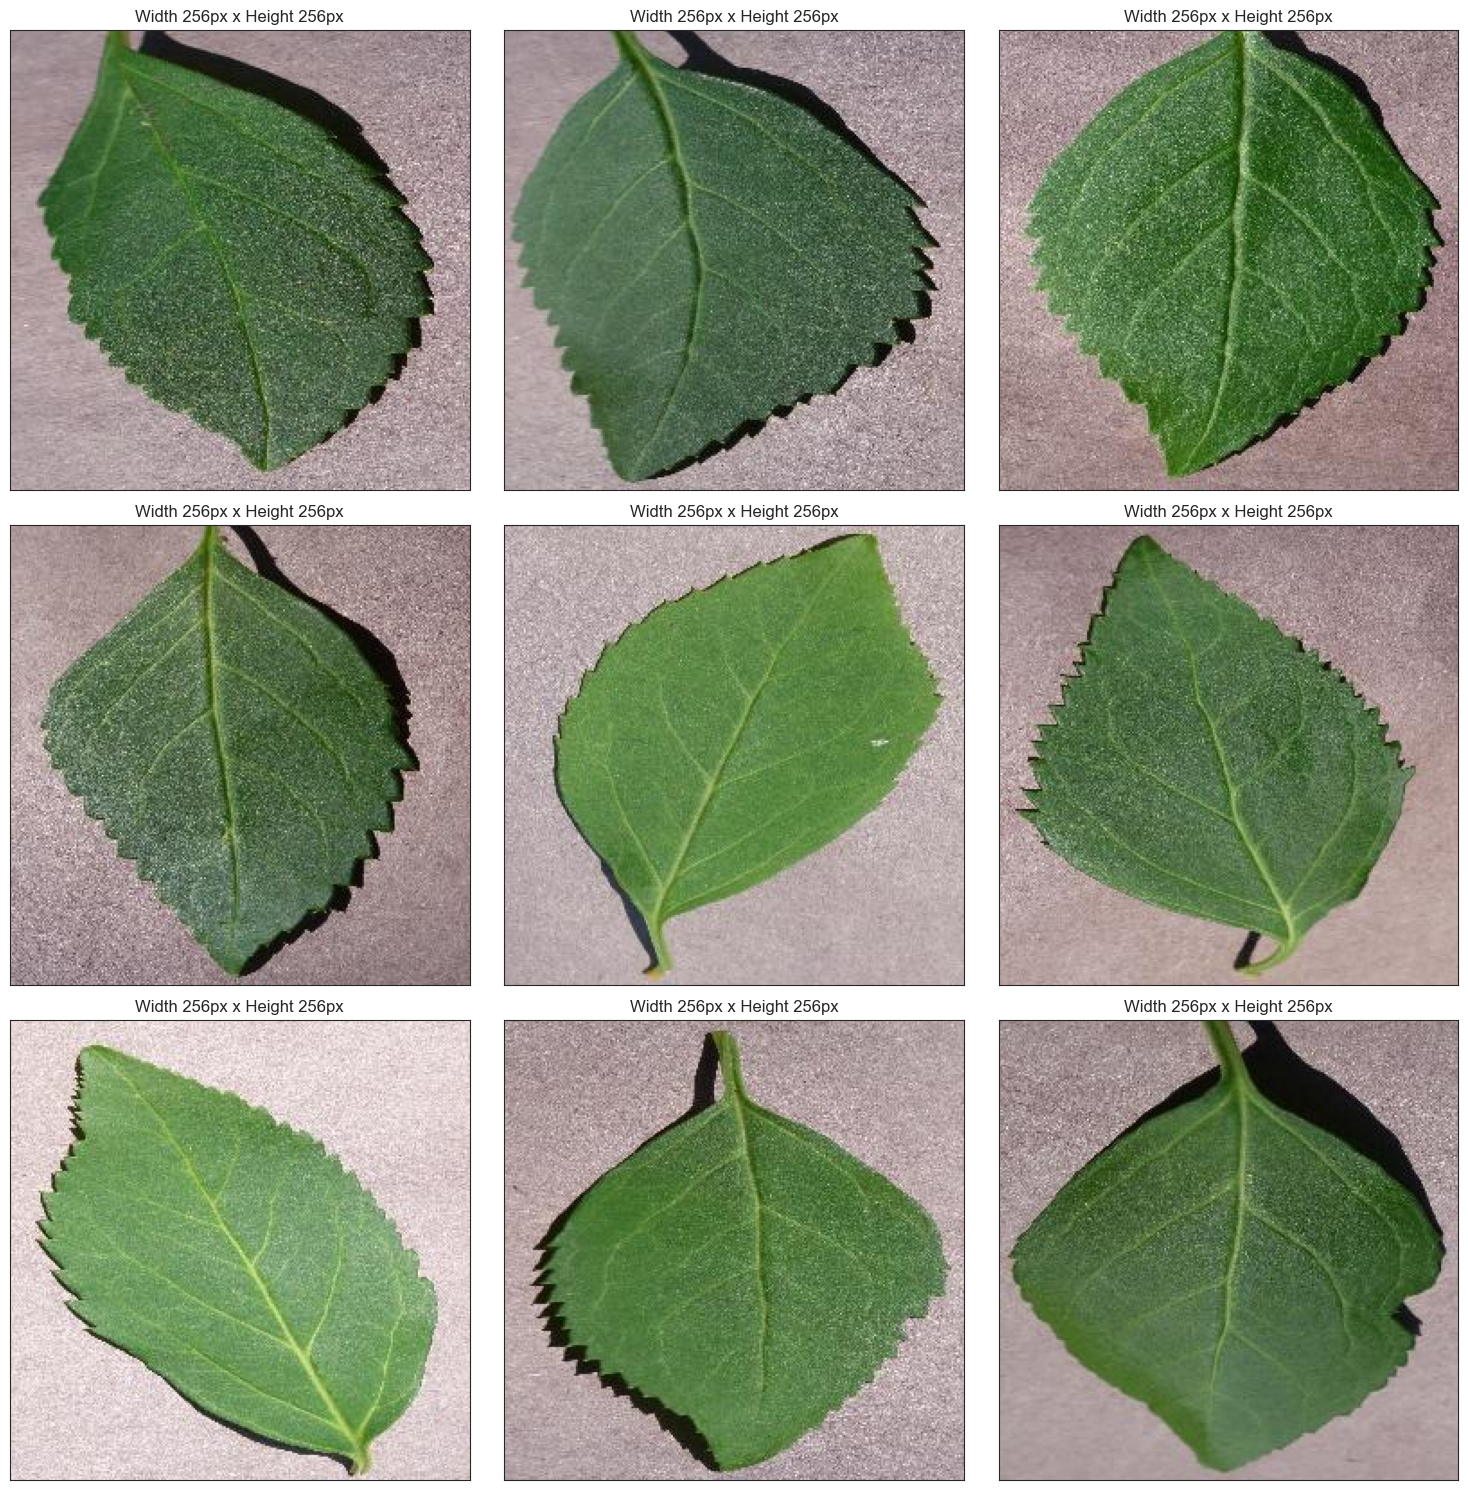



powdery_mildew


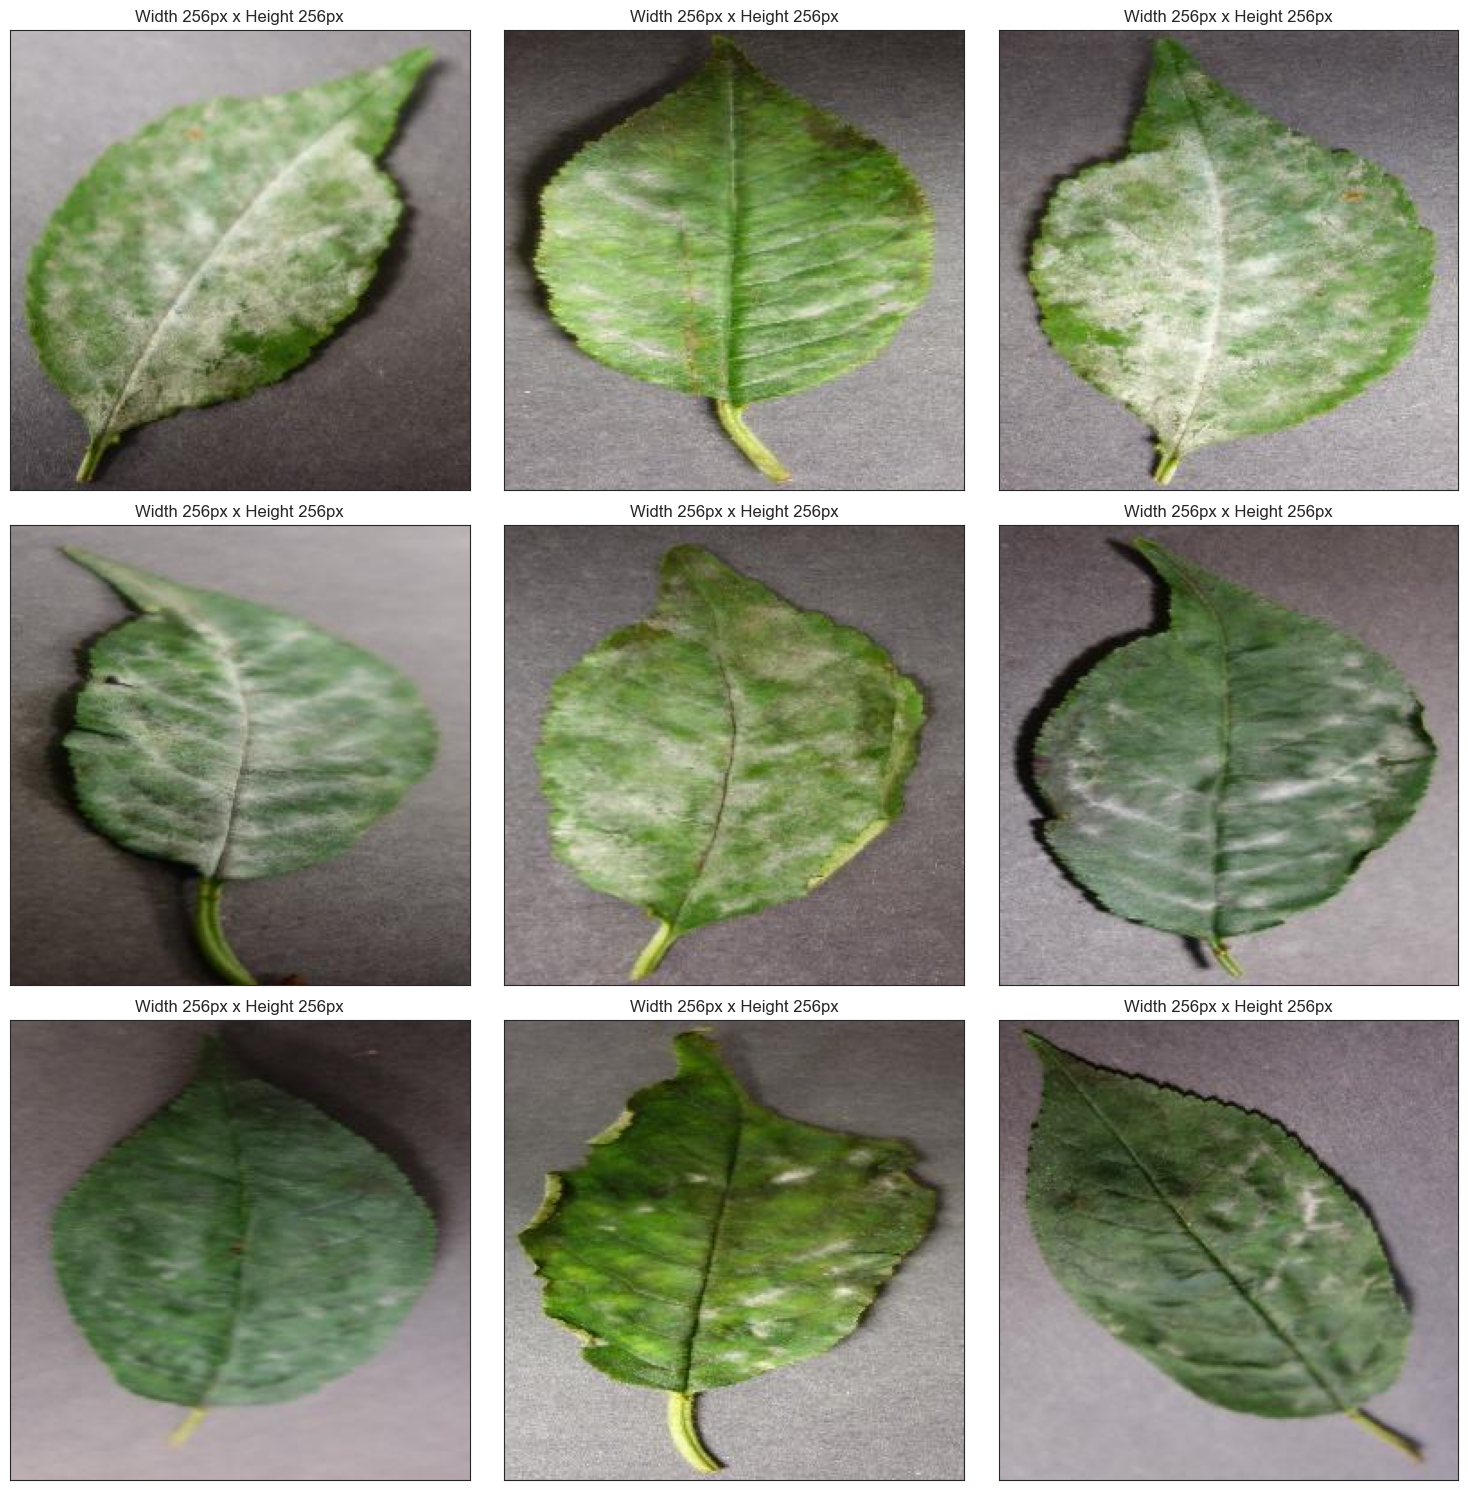

In [64]:
for label in labels:
    print(label)
    image_montage(dir_path=train_path,
                  label_to_display=label,
                  nrows=3, ncols=3,
                  figsize=(15, 15)
                  )
    print("\n")

---

# Push files to Repo

In [75]:
! git add .

The file will have its original line endings in your working directory
The file will have its original line endings in your working directory


In [77]:
! git commit -am"Add updated plots"

On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean


In [78]:
! git push
print("test")

To https://github.com/yuyizhong/ML-Mildew-Detector-.git
   4582121..8bd6add  main -> main
